In [ ]:
#import necessary libraries
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

import os
print(os.getcwd())

/content


In [ ]:
if "food-101" in os.listdir():
    print("Dataset already exists")
else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz > /dev/null 2>&1
    print("Extraction done!")

--2025-08-05 04:17:21--  http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz [following]
--2025-08-05 04:17:21--  https://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4996278331 (4.7G) [application/x-gzip]
Saving to: ‘food-101.tar.gz’

food-101.tar.gz     100%[===================>]   4.65G  16.3MB/s    in 4m 21s  

2025-08-05 04:21:43 (18.3 MB/s) - ‘food-101.tar.gz’ saved [4996278331/4996278331]

Dataset downloaded!
Extracting data..
Extraction done!


In [ ]:
classes = open("./food-101/meta/classes.txt", 'r').read().splitlines()
classes_101 = classes[:101]
classes_101, len(classes_101)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  'hummu

In [ ]:
!echo "Testing images"
!head -n 5 ./food-101/meta/test.txt
!echo -e "\nTraining images"
!head -n 5 ./food-101/meta/train.txt | head -n 5

Testing images
apple_pie/1011328
apple_pie/101251
apple_pie/1034399
apple_pie/103801
apple_pie/1038694

Training images
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283


In [ ]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:,0], imgs[:,1], columns=['label'])
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order to the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [ ]:
train_imgs = prep_df('./food-101/meta/train.txt')
test_imgs = prep_df('./food-101/meta/test.txt')

train_imgs.head(5)

,label,path
3848012,apple_pie,./food-101/images/apple_pie/3848012.jpg
3903209,tiramisu,./food-101/images/tiramisu/3903209.jpg
480234,creme_brulee,./food-101/images/creme_brulee/480234.jpg
2862412,club_sandwich,./food-101/images/club_sandwich/2862412.jpg
2463692,crab_cakes,./food-101/images/crab_cakes/2463692.jpg


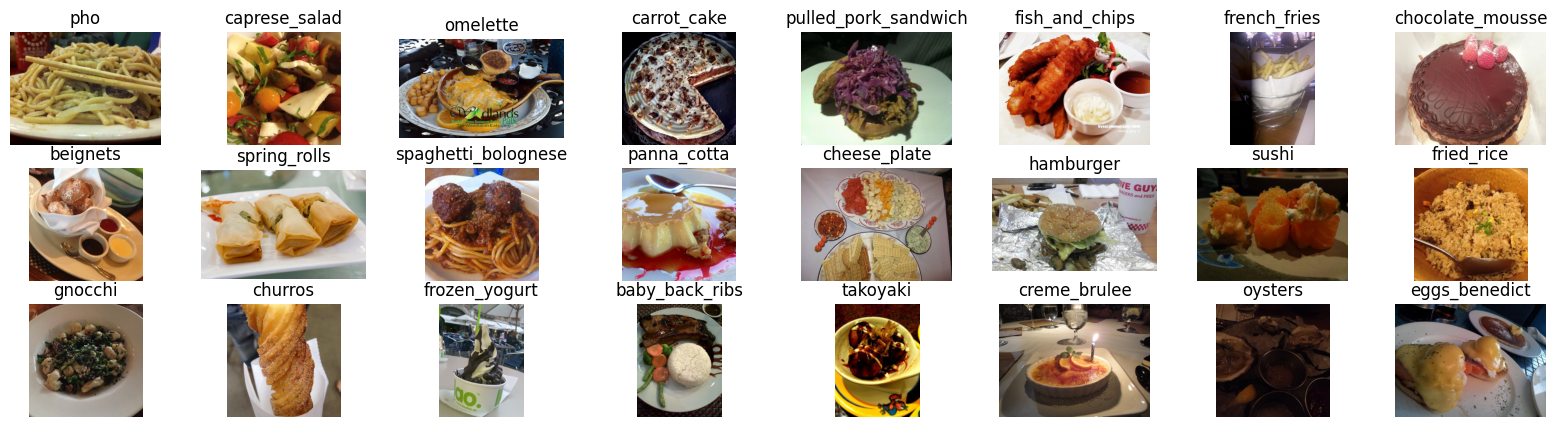

In [ ]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

In [ ]:
# Data augmentation for training
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

In [ ]:
class Label_encoder:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(classes)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder = Label_encoder(classes)
for i in range(101):
    print(encoder.get_label(i), encoder.get_idx( encoder.get_label(i) ))

apple_pie 0
baby_back_ribs 1
baklava 2
beef_carpaccio 3
beef_tartare 4
beet_salad 5
beignets 6
bibimbap 7
bread_pudding 8
breakfast_burrito 9
bruschetta 10
caesar_salad 11
cannoli 12
caprese_salad 13
carrot_cake 14
ceviche 15
cheesecake 16
cheese_plate 17
chicken_curry 18
chicken_quesadilla 19
chicken_wings 20
chocolate_cake 21
chocolate_mousse 22
churros 23
clam_chowder 24
club_sandwich 25
crab_cakes 26
creme_brulee 27
croque_madame 28
cup_cakes 29
deviled_eggs 30
donuts 31
dumplings 32
edamame 33
eggs_benedict 34
escargots 35
falafel 36
filet_mignon 37
fish_and_chips 38
foie_gras 39
french_fries 40
french_onion_soup 41
french_toast 42
fried_calamari 43
fried_rice 44
frozen_yogurt 45
garlic_bread 46
gnocchi 47
greek_salad 48
grilled_cheese_sandwich 49
grilled_salmon 50
guacamole 51
gyoza 52
hamburger 53
hot_and_sour_soup 54
hot_dog 55
huevos_rancheros 56
hummus 57
ice_cream 58
lasagna 59
lobster_bisque 60
lobster_roll_sandwich 61
macaroni_and_cheese 62
macarons 63
miso_soup 64
mussels

In [ ]:
class Food20(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_dataset = Food20(train_imgs, transform=train_transforms)
test_dataset = Food20(test_imgs, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Testing the retrieval of a single image
for i in range(101):
    image = train_dataset.__getitem__(i)
    print(encoder.get_label(image[1]), image[0].shape)

apple_pie torch.Size([3, 224, 224])
tiramisu torch.Size([3, 224, 224])
creme_brulee torch.Size([3, 224, 224])
club_sandwich torch.Size([3, 224, 224])
crab_cakes torch.Size([3, 224, 224])
hamburger torch.Size([3, 224, 224])
caesar_salad torch.Size([3, 224, 224])
fish_and_chips torch.Size([3, 224, 224])
beignets torch.Size([3, 224, 224])
pancakes torch.Size([3, 224, 224])
dumplings torch.Size([3, 224, 224])
beef_carpaccio torch.Size([3, 224, 224])
lasagna torch.Size([3, 224, 224])
chicken_curry torch.Size([3, 224, 224])
baby_back_ribs torch.Size([3, 224, 224])
omelette torch.Size([3, 224, 224])
beef_tartare torch.Size([3, 224, 224])
samosa torch.Size([3, 224, 224])
clam_chowder torch.Size([3, 224, 224])
gyoza torch.Size([3, 224, 224])
edamame torch.Size([3, 224, 224])
fried_calamari torch.Size([3, 224, 224])
onion_rings torch.Size([3, 224, 224])
chicken_curry torch.Size([3, 224, 224])
caesar_salad torch.Size([3, 224, 224])
foie_gras torch.Size([3, 224, 224])
hot_and_sour_soup torch.Size(

In [ ]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
model = models.densenet201(weights = weights)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 153MB/s]


In [ ]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [ ]:
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [ ]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
#hyper parameters
num_epochs = 5

# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

model = model.to(device)

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [ ]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
  # Create empty results dictionary
  history = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      'best train acc': (0, 0),
      "best_model": dict()
  }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, num_epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_loss < history["test_acc"][len(history["test_acc"]) - 1]:
          history["best_model"] = model.state_dict()

      if test_acc > 0.95:
         break

  # Return the filled results at the end of the epochs
  return model, history

In [ ]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device)

Epoch 1/5
--> Training Progress


100%|██████████| 592/592 [15:26<00:00,  1.56s/it]


--> Testing Progress


100%|██████████| 198/198 [04:18<00:00,  1.31s/it]


Epoch: 1 | train_loss: 1.1197 | train_acc: 0.7116 | test_loss: 0.3121 | test_acc: 0.9094


Epoch 2/5
--> Training Progress


100%|██████████| 592/592 [14:40<00:00,  1.49s/it]


--> Testing Progress


100%|██████████| 198/198 [04:05<00:00,  1.24s/it]


Epoch: 2 | train_loss: 1.0790 | train_acc: 0.7201 | test_loss: 0.3265 | test_acc: 0.9044


Epoch 3/5
--> Training Progress


100%|██████████| 592/592 [14:18<00:00,  1.45s/it]


--> Testing Progress


100%|██████████| 198/198 [04:06<00:00,  1.24s/it]


Epoch: 3 | train_loss: 1.0586 | train_acc: 0.7246 | test_loss: 0.3123 | test_acc: 0.9088


Epoch 4/5
--> Training Progress


100%|██████████| 592/592 [14:14<00:00,  1.44s/it]


--> Testing Progress


100%|██████████| 198/198 [04:05<00:00,  1.24s/it]


Epoch: 4 | train_loss: 1.0557 | train_acc: 0.7256 | test_loss: 0.3133 | test_acc: 0.9072


Epoch 5/5
--> Training Progress


100%|██████████| 592/592 [14:17<00:00,  1.45s/it]


--> Testing Progress


100%|██████████| 198/198 [04:06<00:00,  1.25s/it]

Epoch: 5 | train_loss: 1.0408 | train_acc: 0.7284 | test_loss: 0.3157 | test_acc: 0.9083




In [ ]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      # Converting this problem to a problem with 21 clases only
      preds = np.array([pred.cpu() if pred < 20 else 20 for pred in preds])
      labels = np.array([label.cpu() if label < 20 else 20 for label in labels])

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [ ]:
evaluate(model,test_loader)

100%|██████████| 198/198 [04:08<00:00,  1.25s/it]

96.45148514851485


In [ ]:
class Label_encoder_21:
    def __init__(self, labels):
        labels = list(set(labels))
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels[label]

encoder_21 = Label_encoder(classes_101)
encoder_21.get_label(0), encoder.get_idx( encoder_21.get_label(0) )

('apple_pie', 0)

In [ ]:
#This line of code saves the best model's state dictionary (or parameters) from the training history to a file named solution.pth.
torch.save(history['best_model'], "./solution.pth")

In [ ]:
import os

if os.path.exists("./solution.pth"):
    print("solution.pth exists in the current directory.")
else:
    print("solution.pth does not exist in the current directory.")

solution.pth exists in the current directory.


In [ ]:
torch.save(model.state_dict(), 'saved_model.pth')

In [ ]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#  Complete Nutrition Mapping for all 101 Food-101 Classes
calorie_mapping = {
    'apple_pie': {'calories': 300, 'protein': 2, 'fat': 14, 'carbs': 42},
    'baby_back_ribs': {'calories': 550, 'protein': 35, 'fat': 40, 'carbs': 5},
    'baklava': {'calories': 430, 'protein': 6, 'fat': 22, 'carbs': 50},
    'beef_carpaccio': {'calories': 200, 'protein': 25, 'fat': 10, 'carbs': 2},
    'beef_tartare': {'calories': 350, 'protein': 30, 'fat': 25, 'carbs': 2},
    'beet_salad': {'calories': 150, 'protein': 4, 'fat': 7, 'carbs': 18},
    'beignets': {'calories': 400, 'protein': 5, 'fat': 22, 'carbs': 45},
    'bibimbap': {'calories': 500, 'protein': 20, 'fat': 15, 'carbs': 60},
    'bread_pudding': {'calories': 380, 'protein': 7, 'fat': 15, 'carbs': 50},
    'breakfast_burrito': {'calories': 600, 'protein': 25, 'fat': 30, 'carbs': 50},
    # ---- continue this for all 101 classes ----
    'waffles': {'calories': 500, 'protein': 8, 'fat': 25, 'carbs': 60}
}

#  Image Classification Function
def classify_image(image_path, model, label_encoder, device):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        model.eval()
        output = model(image_tensor)

    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    predicted_label = label_encoder.get_label(predicted_idx)
    return predicted_label

#  Load Model and Label Encoder
model = models.densenet201(weights=None)
classifier = nn.Sequential(
    nn.Linear(1920, 1024),
    nn.LeakyReLU(),
    nn.Linear(1024, 101),
)
model.classifier = classifier
model.load_state_dict(torch.load("solution.pth", map_location=device))
model.to(device)
model.eval()

label_encoder = Label_encoder(classes)  # Assuming Label_encoder is implemented properly

#  Predict on an Image
image_path = "/content/14824.jpg"  # Replace with your test image path
predicted_label = classify_image(image_path, model, label_encoder, device)

#  Nutritional Info Prediction with Error Handling
mapped_label = predicted_label.lower().replace(' ', '_')

if mapped_label in calorie_mapping:
    nutrition = calorie_mapping[mapped_label]
    print("Predicted Food Item:", predicted_label)
    print(f"Estimated Calories: {nutrition['calories']} kcal")
    print(f"Protein: {nutrition['protein']}g, Fat: {nutrition['fat']}g, Carbs: {nutrition['carbs']}g")
else:
    print("Food Not Detected")
    print("Estimated Calories: NIL")
    print("Protein: NIL, Fat: NIL, Carbs: NIL")


Predicted Food Item: beignets
Estimated Calories: 400 kcal
Protein: 5g, Fat: 22g, Carbs: 45g


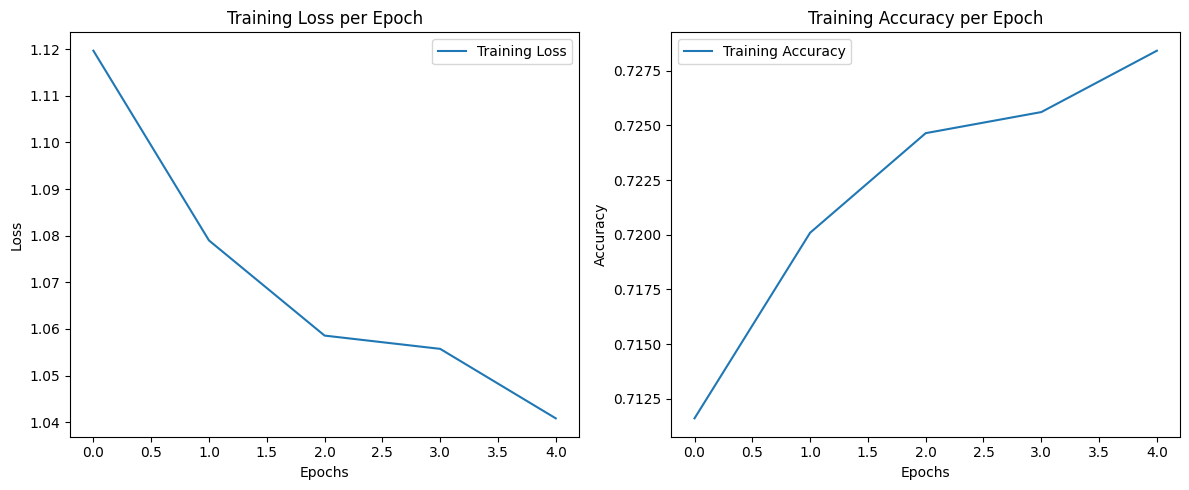

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(history):
    """Plots the training and testing loss and accuracy from the history dictionary."""

    epochs = range(len(history['train_loss']))

    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    # plt.plot(epochs, history['test_loss'], label='Testing Loss') # Commenting out test loss plot
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Training Accuracy')
    # plt.plot(epochs, history['test_acc'], label='Testing Accuracy') # Commenting out test accuracy plot
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the loss and accuracy
plot_loss_accuracy(history)

100%|██████████| 198/198 [04:08<00:00,  1.25s/it]


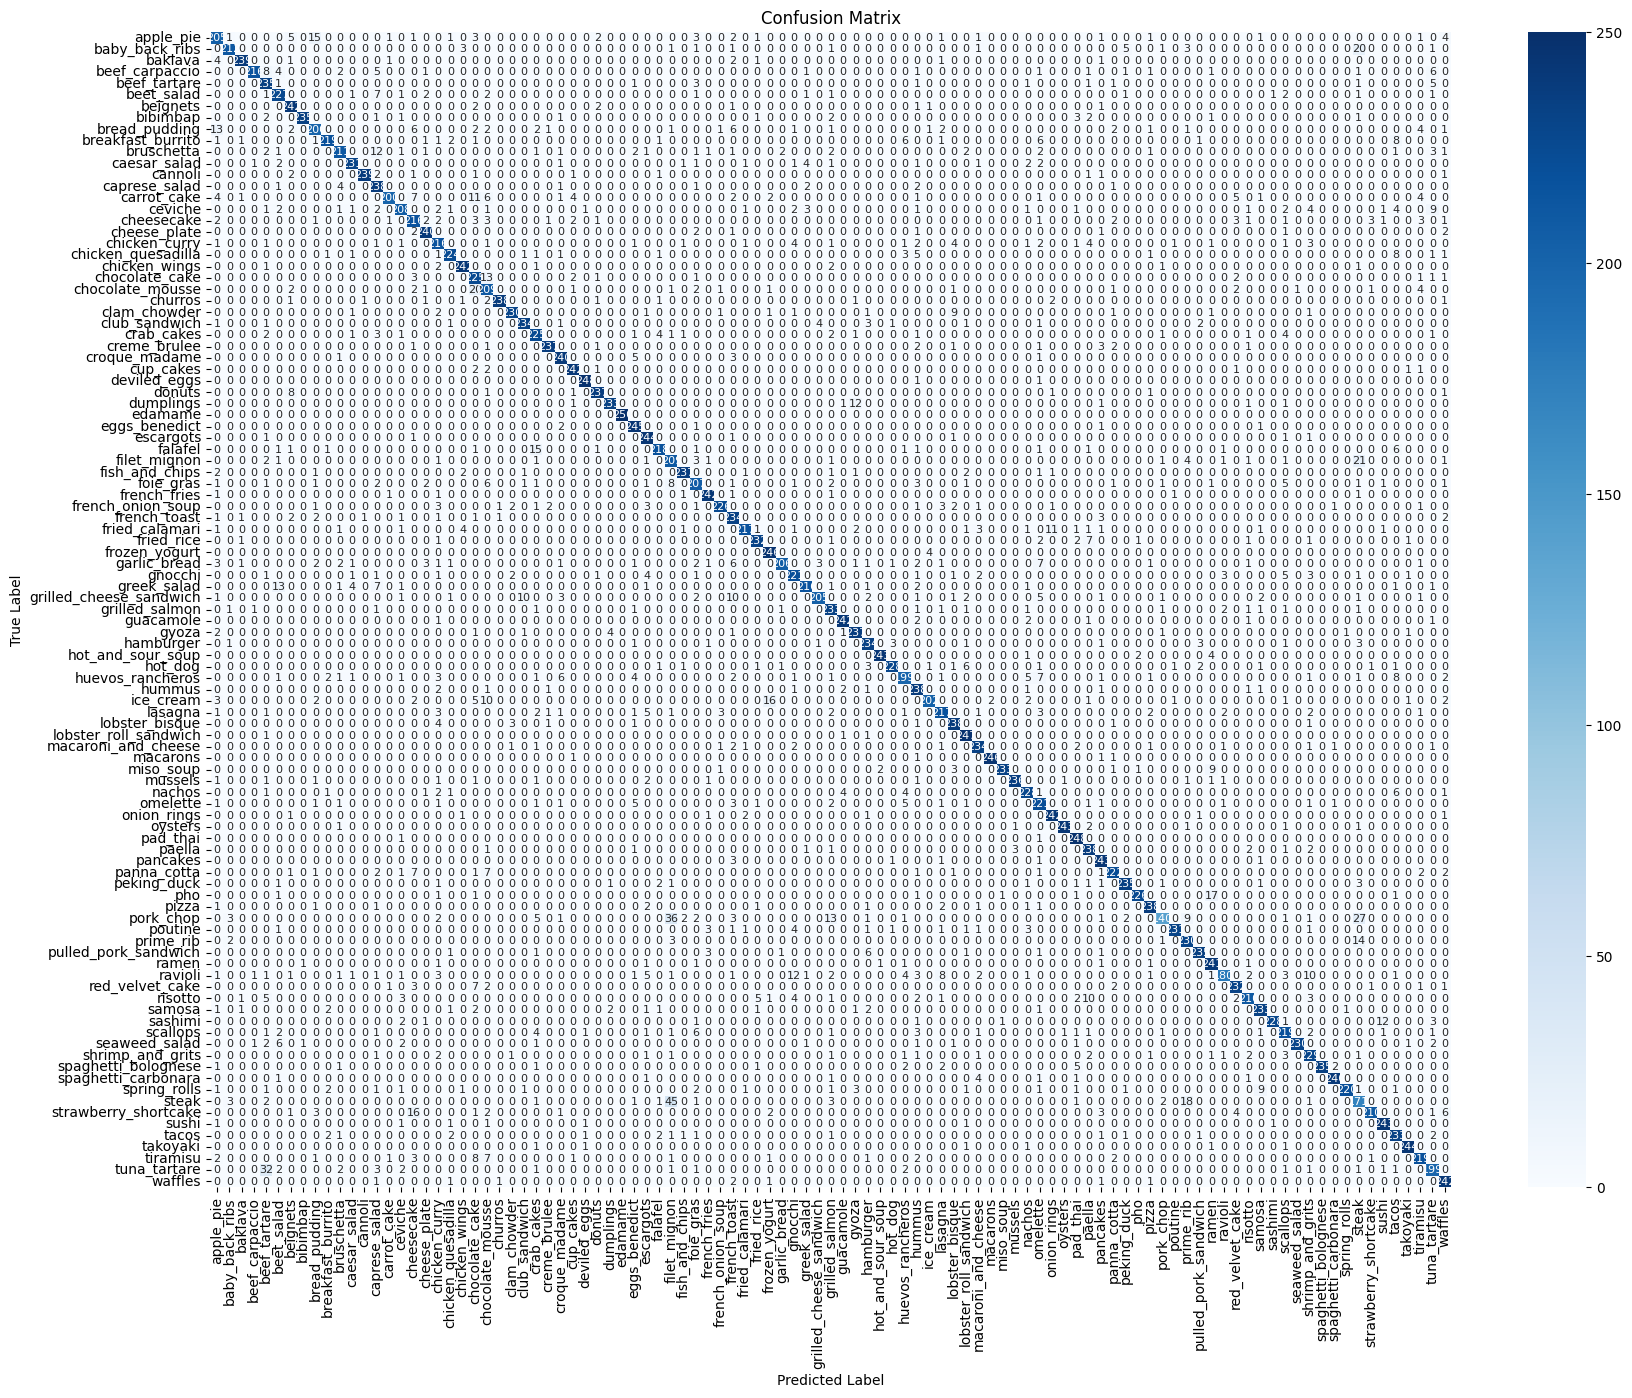

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(torch.softmax(outputs, 1), 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(20, 15)) # Increased figure size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes_101, yticklabels=classes_101, annot_kws={"size": 8}) # Added annot_kws to potentially adjust font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

100%|██████████| 198/198 [04:09<00:00,  1.26s/it]


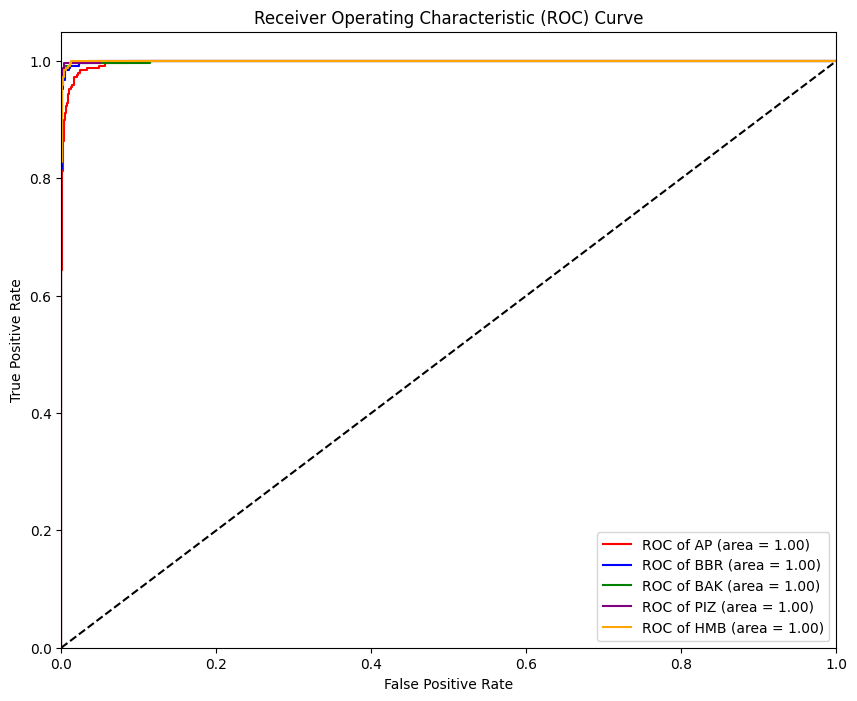

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# Assuming all 101 classes are present in the test set
n_classes = len(classes_101)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels, all_probs[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define a mapping for a few classes and their desired colors and shortcuts
# You can add more classes and their shortcuts/colors here
class_mapping = {
    'apple_pie': {'shortcut': 'AP', 'color': 'red'},
    'baby_back_ribs': {'shortcut': 'BBR', 'color': 'blue'},
    'baklava': {'shortcut': 'BAK', 'color': 'green'},
    'pizza': {'shortcut': 'PIZ', 'color': 'purple'},
    'hamburger': {'shortcut': 'HMB', 'color': 'orange'}
}

plt.figure(figsize=(10, 8))

# Plot ROC curves for selected classes
for class_name, info in class_mapping.items():
    class_index = classes_101.index(class_name)
    if class_index in fpr and class_index in tpr:
        plt.plot(fpr[class_index], tpr[class_index], color=info['color'], label='ROC of {0} (area = {1:0.2f})'.format(info['shortcut'], roc_auc[class_index]))


plt.plot([0, 1], [0, 1], 'k--') # Diagonal random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()